<a href="https://colab.research.google.com/github/tsai-praveen/tsai-assignments/blob/main/s5/S5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = "cuda" if torch.cuda.is_available() else "cpu"

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [9]:
from model import Net, NormType

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
# Keep this separate 

train_losses = {x.value:[] for x in NormType}
test_losses = {x.value:[] for x in NormType}
train_acc = {x.value:[] for x in NormType}
test_acc = {x.value:[] for x in NormType}

In [11]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, norm_type, l1_reg=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_rate = 0.0005
    if l1_reg:
        for x in model.parameters():
            loss += l1_rate * torch.norm(x, p=1)

    train_losses[norm_type.value].append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[norm_type.value].append(100*correct/processed)

def test(model, device, test_loader, norm_type):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[norm_type.value].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[norm_type.value].append(100. * correct / len(test_loader.dataset))

### Display Wrong classifications

In [12]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to show wrongly classified images
def wrong_classifications(model, test_loader):

    wrongly_classified_images = []
    actual_labels = []
    predicted_labels = []

    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    wrongly_classified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(wrongly_classified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


# Group Normalization
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)

curr_normtype = NormType.GROUPNORM
model = Net(norm_type=curr_normtype).to(device)
print(summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─GroupNorm: 2-3                    [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─GroupNorm: 2-7                    [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [16]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, curr_normtype)
    scheduler.step()
    test(model, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.22607670724391937 Batch_id=468 Accuracy=82.73: 100%|██████████| 469/469 [00:07<00:00, 62.33it/s]



Test set: Average loss: 0.2168, Accuracy: 9490/10000 (94.90%)

EPOCH: 2


Loss=0.09737684577703476 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:07<00:00, 65.42it/s] 



Test set: Average loss: 0.1668, Accuracy: 9609/10000 (96.09%)

EPOCH: 3


Loss=0.3171637952327728 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:07<00:00, 66.21it/s]  



Test set: Average loss: 0.1519, Accuracy: 9659/10000 (96.59%)

EPOCH: 4


Loss=0.16872261464595795 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:07<00:00, 66.46it/s] 



Test set: Average loss: 0.1518, Accuracy: 9659/10000 (96.59%)

EPOCH: 5


Loss=0.23262518644332886 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:07<00:00, 66.38it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 6


Loss=0.2612208425998688 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:07<00:00, 65.11it/s]  



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 7


Loss=0.2519529163837433 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:07<00:00, 65.88it/s]  



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 8


Loss=0.1511102318763733 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:07<00:00, 66.20it/s]  



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 9


Loss=0.13870729506015778 Batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:07<00:00, 64.45it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 10


Loss=0.15186332166194916 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:07<00:00, 65.56it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 11


Loss=0.25308722257614136 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:07<00:00, 64.69it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 12


Loss=0.1707405298948288 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:07<00:00, 64.07it/s]  



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 13


Loss=0.20883996784687042 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:07<00:00, 64.85it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 14


Loss=0.24271874129772186 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:07<00:00, 64.82it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 15


Loss=0.2293870449066162 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:07<00:00, 61.82it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 16


Loss=0.12937118113040924 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:07<00:00, 64.38it/s]



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 17


Loss=0.2016933411359787 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:07<00:00, 63.19it/s] 



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 18


Loss=0.21627824008464813 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:07<00:00, 61.49it/s]



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 19


Loss=0.19478392601013184 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:07<00:00, 62.84it/s]



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)

EPOCH: 20


Loss=0.21370510756969452 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:07<00:00, 60.21it/s]



Test set: Average loss: 0.1518, Accuracy: 9660/10000 (96.60%)



### Wrong classifications

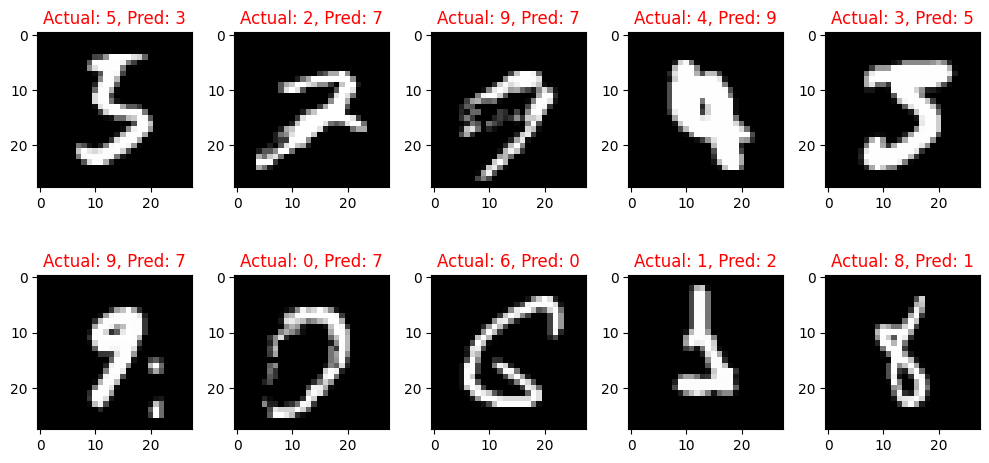

In [17]:
wrong_classifications(model, test_loader)

# Layer Normalization

In [61]:
curr_normtype = NormType.LAYERNORM
model_ln = Net(norm_type=curr_normtype).to(device)
print(summary(model_ln, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─LayerNorm: 2-3                    [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─LayerNorm: 2-7                    [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [62]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model_ln, device, train_loader, optimizer, epoch, curr_normtype)
    # scheduler.step()
    test(model_ln, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.2513810694217682 Batch_id=468 Accuracy=81.87: 100%|██████████| 469/469 [00:07<00:00, 63.77it/s]  



Test set: Average loss: 0.1904, Accuracy: 9563/10000 (95.63%)

EPOCH: 2


Loss=0.12033303827047348 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:07<00:00, 63.89it/s]



Test set: Average loss: 0.0911, Accuracy: 9802/10000 (98.02%)

EPOCH: 3


Loss=0.06432037055492401 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:07<00:00, 64.64it/s]  



Test set: Average loss: 0.0759, Accuracy: 9808/10000 (98.08%)

EPOCH: 4


Loss=0.02956913411617279 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:07<00:00, 66.46it/s]  



Test set: Average loss: 0.0568, Accuracy: 9844/10000 (98.44%)

EPOCH: 5


Loss=0.059558067470788956 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:06<00:00, 67.17it/s] 



Test set: Average loss: 0.0565, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.05222969874739647 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:07<00:00, 65.46it/s]  



Test set: Average loss: 0.0400, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.04195364937186241 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:07<00:00, 66.41it/s]  



Test set: Average loss: 0.0378, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.03020690195262432 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:07<00:00, 66.25it/s]  



Test set: Average loss: 0.0441, Accuracy: 9866/10000 (98.66%)

EPOCH: 9


Loss=0.0340188629925251 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:07<00:00, 65.92it/s]   



Test set: Average loss: 0.0374, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.10778326541185379 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:07<00:00, 66.40it/s]  



Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.0386233776807785 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:07<00:00, 63.14it/s]   



Test set: Average loss: 0.0347, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


Loss=0.04668687656521797 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:07<00:00, 62.73it/s] 



Test set: Average loss: 0.0289, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.012583885341882706 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:07<00:00, 59.44it/s]



Test set: Average loss: 0.0299, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.1217014417052269 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:08<00:00, 58.38it/s]  



Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.01600182242691517 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:07<00:00, 62.58it/s] 



Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.0273449569940567 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:07<00:00, 62.94it/s]   



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 17


Loss=0.04093899577856064 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:07<00:00, 63.74it/s] 



Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.058194804936647415 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:07<00:00, 59.10it/s] 



Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.017646558582782745 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:07<00:00, 58.72it/s] 



Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

EPOCH: 20


Loss=0.004516031127423048 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:07<00:00, 62.43it/s]



Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)



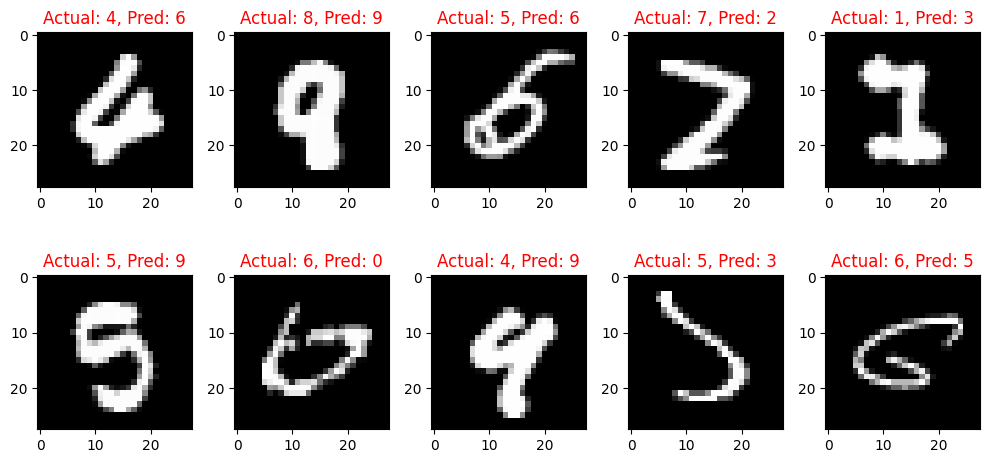

In [63]:
wrong_classifications(model_ln, test_loader)

# Batch Normalization + L1 Regularization

In [64]:
curr_normtype = NormType.BATCHNORM
model_bn = Net(norm_type=curr_normtype).to(device)
print(summary(model_bn, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─BatchNorm2d: 2-7                  [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [65]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model_bn, device, train_loader, optimizer, epoch, curr_normtype, True)
    scheduler.step()
    test(model_bn, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.398801326751709 Batch_id=468 Accuracy=85.02: 100%|██████████| 469/469 [00:07<00:00, 64.18it/s]   



Test set: Average loss: 0.1536, Accuracy: 9669/10000 (96.69%)

EPOCH: 2


Loss=0.3058604598045349 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:07<00:00, 63.62it/s]  



Test set: Average loss: 0.1265, Accuracy: 9754/10000 (97.54%)

EPOCH: 3


Loss=0.36785033345222473 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:07<00:00, 63.55it/s]



Test set: Average loss: 0.1216, Accuracy: 9754/10000 (97.54%)

EPOCH: 4


Loss=0.3363356590270996 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:07<00:00, 65.59it/s]  



Test set: Average loss: 0.1198, Accuracy: 9767/10000 (97.67%)

EPOCH: 5


Loss=0.3358480632305145 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:07<00:00, 65.40it/s]  



Test set: Average loss: 0.1209, Accuracy: 9761/10000 (97.61%)

EPOCH: 6


Loss=0.37436679005622864 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:07<00:00, 64.35it/s]



Test set: Average loss: 0.1200, Accuracy: 9763/10000 (97.63%)

EPOCH: 7


Loss=0.33581745624542236 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s]



Test set: Average loss: 0.1244, Accuracy: 9754/10000 (97.54%)

EPOCH: 8


Loss=0.3979514539241791 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:08<00:00, 57.57it/s] 



Test set: Average loss: 0.1229, Accuracy: 9745/10000 (97.45%)

EPOCH: 9


Loss=0.33535096049308777 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:08<00:00, 57.50it/s]



Test set: Average loss: 0.1203, Accuracy: 9764/10000 (97.64%)

EPOCH: 10


Loss=0.3550904393196106 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:07<00:00, 60.08it/s] 



Test set: Average loss: 0.1187, Accuracy: 9767/10000 (97.67%)

EPOCH: 11


Loss=0.33221152424812317 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:07<00:00, 59.10it/s]



Test set: Average loss: 0.1194, Accuracy: 9769/10000 (97.69%)

EPOCH: 12


Loss=0.3351837992668152 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:07<00:00, 62.13it/s]  



Test set: Average loss: 0.1213, Accuracy: 9765/10000 (97.65%)

EPOCH: 13


Loss=0.3807050883769989 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:07<00:00, 65.53it/s]  



Test set: Average loss: 0.1205, Accuracy: 9756/10000 (97.56%)

EPOCH: 14


Loss=0.33300119638442993 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:07<00:00, 61.98it/s]



Test set: Average loss: 0.1210, Accuracy: 9764/10000 (97.64%)

EPOCH: 15


Loss=0.3597460687160492 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:07<00:00, 59.21it/s] 



Test set: Average loss: 0.1235, Accuracy: 9755/10000 (97.55%)

EPOCH: 16


Loss=0.3468800187110901 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:08<00:00, 57.41it/s] 



Test set: Average loss: 0.1234, Accuracy: 9756/10000 (97.56%)

EPOCH: 17


Loss=0.3425098955631256 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:07<00:00, 59.18it/s] 



Test set: Average loss: 0.1213, Accuracy: 9766/10000 (97.66%)

EPOCH: 18


Loss=0.3257826268672943 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:07<00:00, 60.83it/s] 



Test set: Average loss: 0.1187, Accuracy: 9765/10000 (97.65%)

EPOCH: 19


Loss=0.30387943983078003 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:07<00:00, 62.24it/s]



Test set: Average loss: 0.1235, Accuracy: 9747/10000 (97.47%)

EPOCH: 20


Loss=0.34514033794403076 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:07<00:00, 63.41it/s] 



Test set: Average loss: 0.1193, Accuracy: 9767/10000 (97.67%)



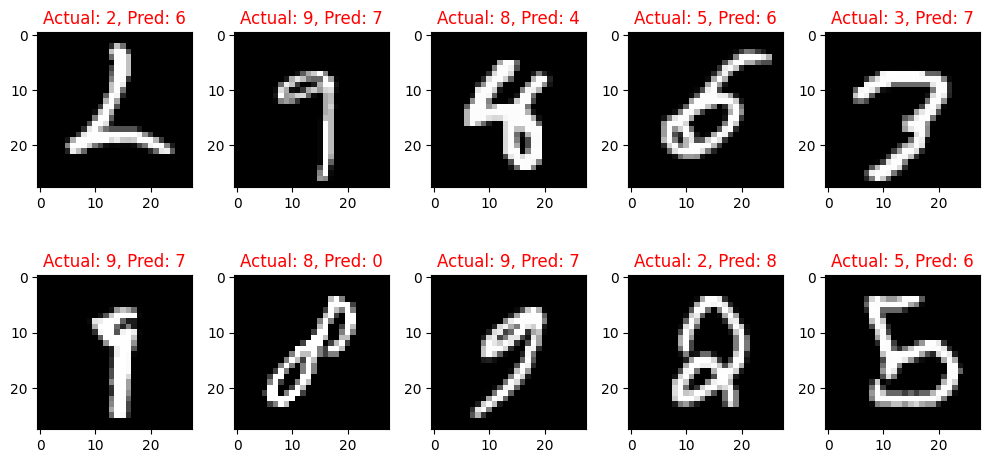

In [66]:
wrong_classifications(model_bn, test_loader)

# Plot our losses

In [67]:
len(train_losses['GN']), len(train_losses['LN']), len(train_losses['BN'])

(9380, 15008, 30954)

In [69]:
tr_losses = dict()
tr_losses["GN"] = [x.cpu().item() for x in train_losses["GN"]]
tr_losses["LN"] = [x.cpu().item() for x in train_losses["LN"]]
tr_losses["BN"] = [x.cpu().item() for x in train_losses["BN"]]
print(tr_losses.keys())

dict_keys(['GN', 'LN', 'BN'])


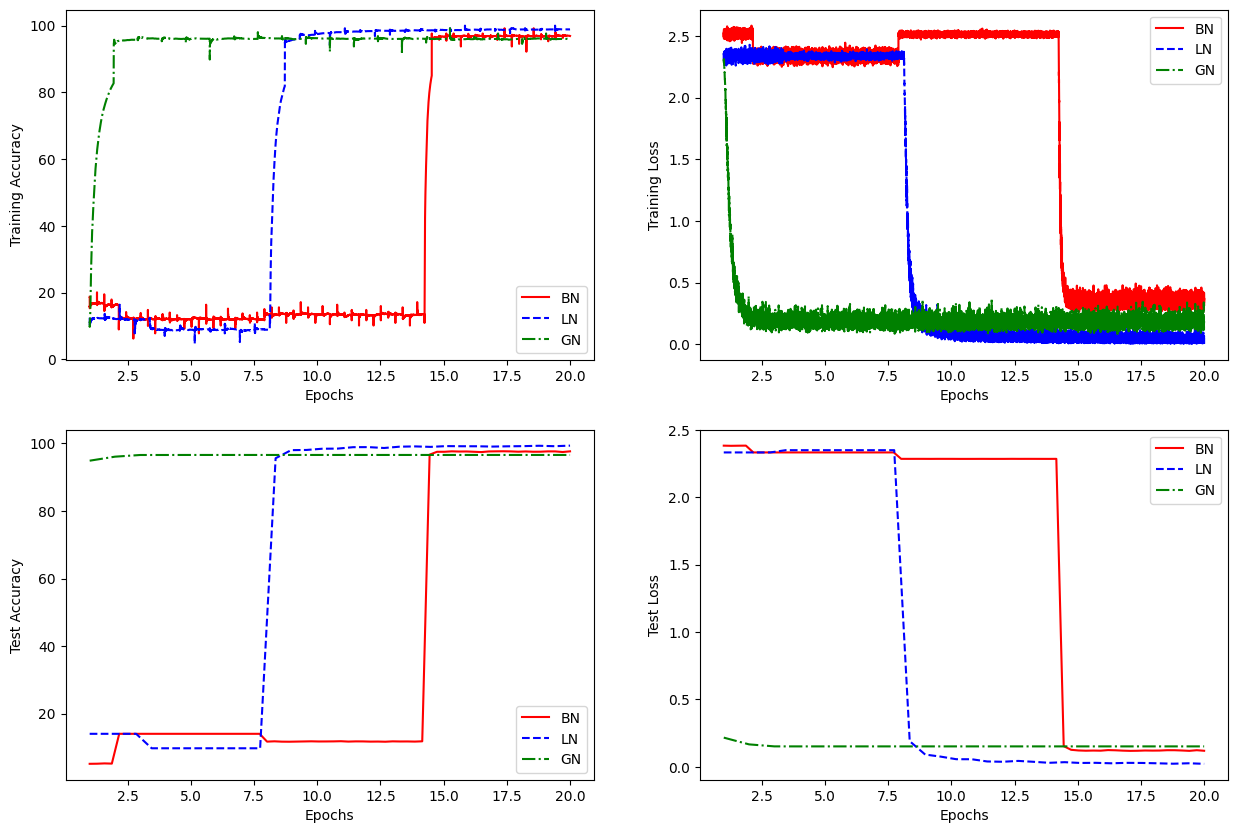

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,2,figsize=(15,10))
plot_meta = {
                "BN":{"color":"red", "pattern": "-"},
                "LN":{"color":"blue", "pattern": "--"},
                "GN":{"color":"green", "pattern": "-."}
            }

def set_plot_details(graph, ylabel):
    graph.set_xlabel('Epochs')
    graph.set_ylabel(ylabel)
    graph.tick_params(axis='y')
    graph.legend(plot_meta.keys())

for norm_type in NormType:
    ntype = str(norm_type.value)
    color, pattern = plot_meta[ntype].values()
    train_epoch_adjusted = np.linspace(1, EPOCHS, len(train_losses[ntype]))
    test_epoch_adjusted = np.linspace(1, EPOCHS, len(test_losses[ntype]))
    axs[0, 0].plot(train_epoch_adjusted, train_acc[ntype], color=color, linestyle=pattern, label=ntype)
    axs[0, 1].plot(train_epoch_adjusted, tr_losses[ntype], color=color, linestyle=pattern, label=ntype)
    axs[1, 0].plot(test_epoch_adjusted, test_acc[ntype], color=color, linestyle=pattern, label=ntype)
    axs[1, 1].plot(test_epoch_adjusted, test_losses[ntype], color=color, linestyle=pattern, label=ntype)


# axs[0, 0].set_title("Training Accuracy")
set_plot_details(axs[0, 0], "Training Accuracy")
set_plot_details(axs[0, 1], "Training Loss")
set_plot_details(axs[1, 0], "Test Accuracy")
set_plot_details(axs[1, 1], "Test Loss")

# plt.show()